<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/decision_tree/Clasification_Pokemon_DecitionTree_Some_Tecniques_Pre_Prunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# -- Model --
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, metrics

from sklearn.decomposition import PCA


# **Dictionary**
---

- `number`: id of the pokedex
- `name`: name of Pokemon
- `type1`: typel
- `type2`: second typel
- `total`: total of statistics
- `hp`: life
- `attack`: attack
- `defense`: defense
- `sp_attack`: special attack
- `sp_defense`: special defense
- `speed`: speed
- `generation`
- `legendary`: is legendary
  - True: yes
  - False: no


**Configuration**

In [ ]:
sns.set(style="darkgrid")

**Target**

prediction of first type2. And codification of some techniques of pruning

#**Funciones**
---

In [ ]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)


def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        ax.text(p.get_x()+p.get_width()/2., height + 1,height, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

def componentes_principales(data:object,
                            min_explained_variance:int=0.85,
                            min_component:int=3,
                            **kwards)->tuple:
  """simple method of PCA, that return data transform"""
  final_comp = 0
  for comp in range(min_component, data.shape[1]):
    pca = PCA(n_components=comp, **kwards)
    pca.fit(data)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() >= min_explained_variance:
      break

  final_pca = PCA(n_components=final_comp, **kwards)
  final_pca.fit(data)
  data_df = final_pca.transform(data)
  info = "Using {} components, we can explain {}% of the variability\
  in the original data.".format(final_comp,comp_check.sum())

  return data_df, final_pca, info

# **DAta**
---

In [ ]:
path = './data/Pokemon.csv'

data = pd.read_csv(path)

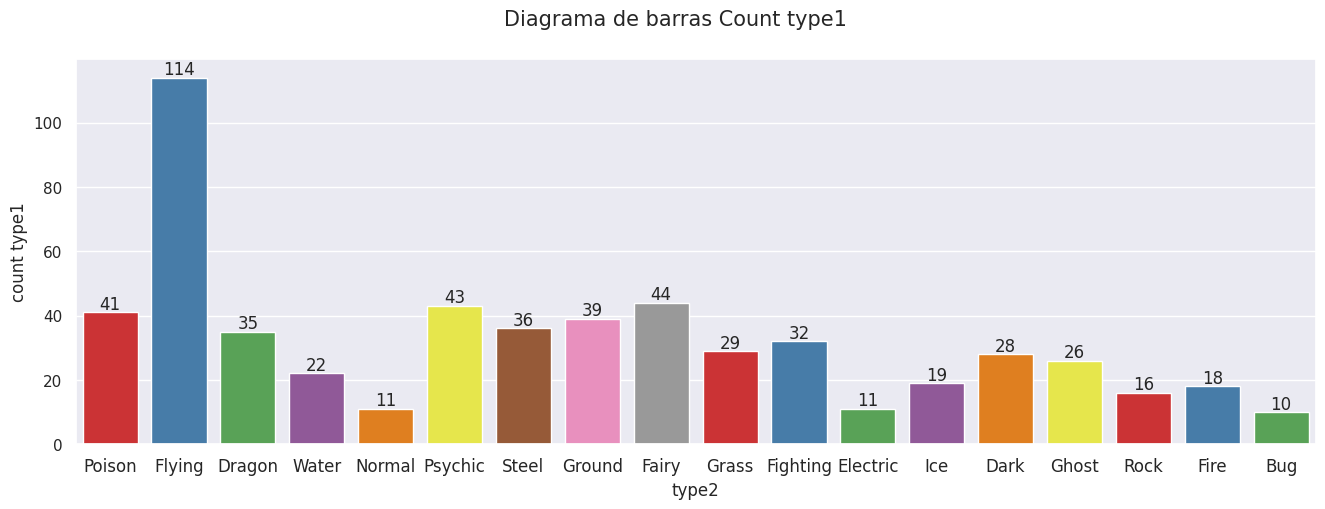

In [ ]:
plot_bar(data, paleta=None, ejeX='type2',
         ejey='count type1',
         title='Count type1', figsize_x=16)

The category whith more rows is:
- Flying
- Fairy
- Poison

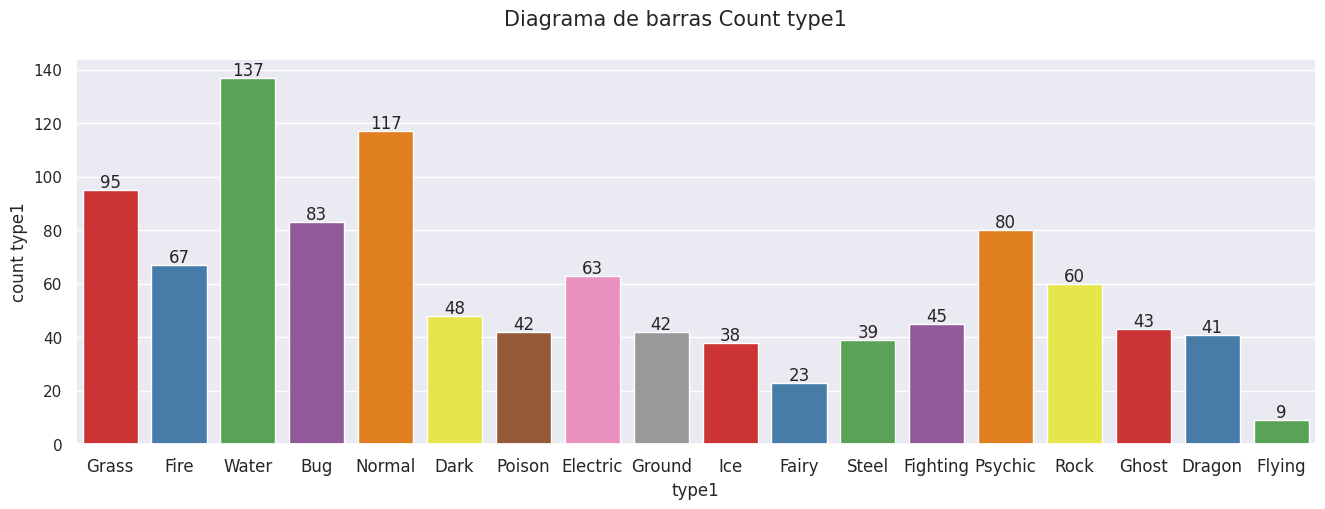

In [ ]:
plot_bar(data, paleta=None, ejeX='type1',
         ejey='count type1',
         title='Count type1', figsize_x=16)

The category whith more rows is:

- Water
- Normal
- Grass

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      1072 non-null   int64 
 1   name        1072 non-null   object
 2   type1       1072 non-null   object
 3   type2       574 non-null    object
 4   total       1072 non-null   int64 
 5   hp          1072 non-null   int64 
 6   attack      1072 non-null   int64 
 7   defense     1072 non-null   int64 
 8   sp_attack   1072 non-null   int64 
 9   sp_defense  1072 non-null   int64 
 10  speed       1072 non-null   int64 
 11  generation  1072 non-null   int64 
 12  legendary   1072 non-null   bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 101.7+ KB


- The type 2 is the only feature with null values, while the rest have all rows
- Three features are of the category type
- Nine features are of the integer type
- One the feature is the bool type
- there are 13 features and 1072 rows

# **Data Split**
---

In [ ]:
data_predict = data[data['type2'].isnull()]
data_train = data[data['type2'].notnull()]

I will select the rows that only have the value not null in the feature "type 2" while the rest feature to use like test cases

No select number and name, because no contribute the information for model

In [ ]:
X = data_train.drop(['number', 'name', 'type2'], axis = 1)
y = data_train['type2']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size= 0.8, stratify=y, random_state=12354, shuffle=True)

# **Preprocess**
---

In [ ]:
feature_category = X.select_dtypes(
    include=['object', 'bool']).columns.to_list()
numeric_columns = X.select_dtypes(
    include=['int64']
).columns.to_list()

In [ ]:
preprocessor = ColumnTransformer(
    [('onehot', OneHotEncoder(), feature_category)],
        remainder = "passthrough"
)

In [ ]:
X_preprocessing_train = preprocessor.fit_transform(X_train)
X_preprocessing_test = preprocessor.transform(X_test)

In [ ]:
categoric_columns = preprocessor.named_transformers_[
    'onehot'].get_feature_names_out(feature_category)
columns_feature = np.concatenate([categoric_columns, numeric_columns])

In [ ]:
X_preprocessing_train =pd.DataFrame(
    X_preprocessing_train, columns=columns_feature)

# **Select the best feature**
---

Only the impurity criterion will be changed. An assembler is used to find the best features.

**Gini**

In [ ]:
model_best_features_gini = ExtraTreesClassifier(
    n_estimators= 100,
    criterion="gini"
)

In [ ]:
data_best_gini = model_best_features_gini.fit(X_preprocessing_train, y_train)

We select the best features, to implement a method to reduce overfitting.

In [ ]:
model_gini = SelectFromModel(data_best_gini, prefit=True)

In [ ]:
X_preprocessing_train[
    X_preprocessing_train.columns[model_gini.get_support(indices=True)]].columns

Index(['total', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed',
       'generation'],
      dtype='object')

**entropy**

In [ ]:
model_best_features_entropy = ExtraTreesClassifier(
    n_estimators= 100,
    criterion="entropy"
)

In [ ]:
data_best_entropy  = model_best_features_entropy.fit(
    X_preprocessing_train, y_train)

We select the best features, to implement a method to reduce overfitting.

In [ ]:
model_entropy = SelectFromModel(data_best_entropy, prefit=True)

In [ ]:
best_feature = X_preprocessing_train[
    X_preprocessing_train.columns[model_gini.get_support(indices=True)]].columns

The same columns were selected in both criteria

In [ ]:
componentes_principales.__doc__

'simple method of PCA, that return data transform'

In [ ]:
X_train = X_train[best_feature]
X_test = X_test[best_feature]

using the PCA method to reduce  dimensionality curse

In [ ]:
len(best_feature)*0.25

2.0

In [ ]:
best_feature

Index(['total', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed',
       'generation'],
      dtype='object')

In [ ]:
data_df, final_pca, info = componentes_principales(
    X_train,
    min_explained_variance=0.85,
    min_component=3)

In [ ]:
data_df

array([[ 148.57444676,   68.36420608,  -36.35362054],
       [ 145.55711102,   18.69220606,    8.71004548],
       [  42.63545912,  -20.14719905,  -19.02141875],
       ...,
       [ -30.70378854,  -31.26023449,   22.67286749],
       [-116.23947904,   24.95304027,  -34.09187509],
       [  45.25013297,   11.99572633,    1.92996504]])

In [ ]:
final_pca

PCA(n_components=3)

In [ ]:
info

'Using 3 components, we can explain 0.9446100881743942% of the variability  in the original data.'

# **Model**
---

**model simple**
---

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

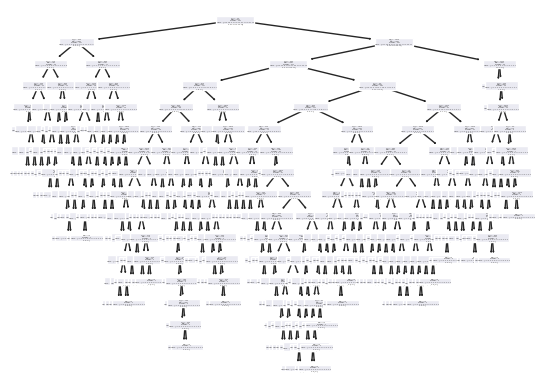

In [ ]:
tree.plot_tree(model)
plt.show()

In [ ]:
model = DecisionTreeClassifier()
model.fit(data_df, y_train)

DecisionTreeClassifier()

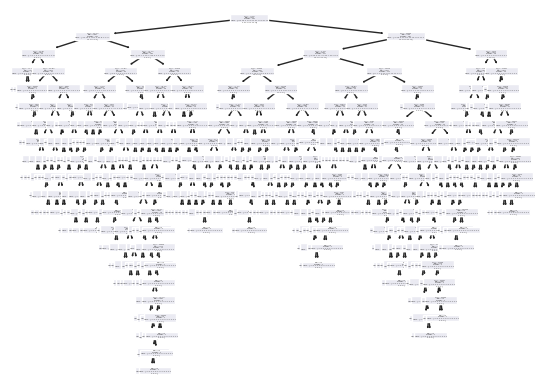

In [ ]:
tree.plot_tree(model)
plt.show()

is a small data set, the model is a trainer without stopping, for see all tree, for n idea of how they should be the hyperparameter of pre pruning

# **Pre - Prunning**
---

In [ ]:
model_pre_pruning = DecisionTreeClassifier(random_state=74)

In [ ]:
criterion = ["gini", "entropy", "log_loss"]
max_depth = [2,4,6, 8]
min_samples_split = [3, 6, 9, 12]
min_samples_leaf = [3, 6, 9]

In [ ]:
param_grid = dict(
    criterion=criterion,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf= min_samples_leaf)

In [ ]:
grid = GridSearchCV(
    estimator = model_pre_pruning,
    param_grid = param_grid,
    refit = True,
    return_train_score = True,
    cv = 10,
)

However the best metric is selected and best score, the objective of the exercise is to understand the pose methods, it is recognized that better techniques can be added

In [ ]:
grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=74),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'min_samples_leaf': [3, 6, 9],
                         'min_samples_split': [3, 6, 9, 12]},
             return_train_score=True)

In [ ]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.239565 usando {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 3}


In [ ]:
grid.fit(data_df, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=74),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'min_samples_leaf': [3, 6, 9],
                         'min_samples_split': [3, 6, 9, 12]},
             return_train_score=True)

In [ ]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.217874 usando {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3}


In [ ]:
grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=74),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'min_samples_leaf': [3, 6, 9],
                         'min_samples_split': [3, 6, 9, 12]},
             return_train_score=True)

In [ ]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
  print('%f (%f) con %r' % (mean, std, param))

0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 6}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 9}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 12}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 3}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 6}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 9}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 12}
0.213527 (0.030538) con {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 3}
0.213527 (0.03053

In [ ]:
model_final = grid.best_estimator_
model_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 74,
 'splitter': 'best'}

# **Pre pruning - with ccp_alpha**
---

In [ ]:
np.linspace(0, 20, 50)

array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
        2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
        4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
        6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
        8.16326531,  8.57142857,  8.97959184,  9.3877551 ,  9.79591837,
       10.20408163, 10.6122449 , 11.02040816, 11.42857143, 11.83673469,
       12.24489796, 12.65306122, 13.06122449, 13.46938776, 13.87755102,
       14.28571429, 14.69387755, 15.10204082, 15.51020408, 15.91836735,
       16.32653061, 16.73469388, 17.14285714, 17.55102041, 17.95918367,
       18.36734694, 18.7755102 , 19.18367347, 19.59183673, 20.        ])

In [ ]:
param_grid = {
    'ccp_alpha':np.linspace(0, 20, 50)
}

In [ ]:
grid = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = param_grid,
    refit=True,
    return_train_score=True,
    cv=10
)

In [ ]:
grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
        2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
        4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
        6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
        8.16326531,  8.57142857,  8.97959184,  9.3877551 ,  9.79591837,
       10.20408163, 10.6122449 , 11.02040816, 11.42857143, 11.83673469,
       12.24489796, 12.65306122, 13.06122449, 13.46938776, 13.87755102,
       14.28571429, 14.69387755, 15.10204082, 15.51020408, 15.91836735,
       16.32653061, 16.73469388, 17.14285714, 17.55102041, 17.95918367,
       18.36734694, 18.7755102 , 19.18367347, 19.59183673, 20.        ])},
             return_train_score=True)

In [ ]:
score = pd.DataFrame(grid.cv_results_)

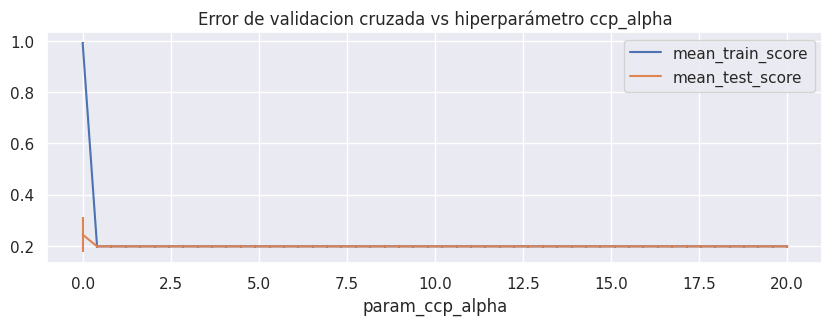

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
score.plot(
    x="param_ccp_alpha", y = 'mean_train_score', yerr='std_train_score', ax=ax)
score.plot(
    x="param_ccp_alpha", y = "mean_test_score",  yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [ ]:
grid.best_params_

{'ccp_alpha': 0.0}

In [ ]:
grid.fit(data_df, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
        2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
        4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
        6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
        8.16326531,  8.57142857,  8.97959184,  9.3877551 ,  9.79591837,
       10.20408163, 10.6122449 , 11.02040816, 11.42857143, 11.83673469,
       12.24489796, 12.65306122, 13.06122449, 13.46938776, 13.87755102,
       14.28571429, 14.69387755, 15.10204082, 15.51020408, 15.91836735,
       16.32653061, 16.73469388, 17.14285714, 17.55102041, 17.95918367,
       18.36734694, 18.7755102 , 19.18367347, 19.59183673, 20.        ])},
             return_train_score=True)

In [ ]:
score = pd.DataFrame(grid.cv_results_)

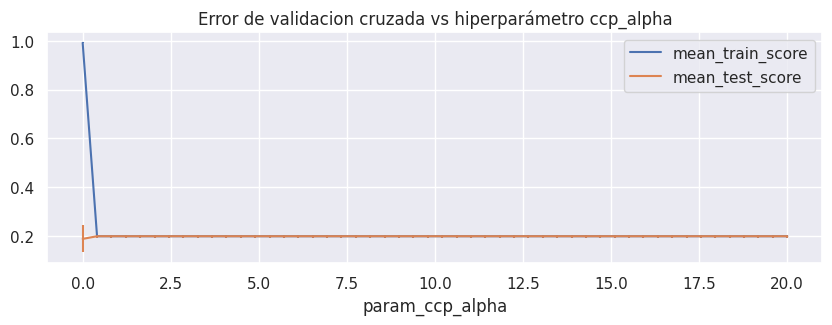

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
score.plot(
    x="param_ccp_alpha", y = 'mean_train_score', yerr='std_train_score', ax=ax)
score.plot(
    x="param_ccp_alpha", y = "mean_test_score",  yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [ ]:
grid.best_params_

{'ccp_alpha': 0.40816326530612246}